In [1]:
reset -fs

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
import warnings
from math import sqrt
from fbprophet import Prophet

In [3]:
def diff(data, interval=1):
    diff = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
    return diff
#trend differencing: interval=1
#seasonal differencing: interval=m


#grid order search based on BIC

def bic_sarima(data, p_values,d_values,q_values,P_values,Q_values,m, D=1):
    best_score, best_order, best_seasonal_order = float("inf"), None, None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                    for P in P_values:
                            for Q in Q_values:
                                order=(p,d,q)
                                seasonal_order=(P,D,Q,m)
                                try:
                                    res = sm.tsa.statespace.SARIMAX(data,order=order,seasonal_order=seasonal_order,enforce_stationarity=False,enforce_invertibility=False).fit()
                                    bic=res.bic
                                    if bic < best_score:
                                        best_score, best_order, best_seasonal_order=bic, order,seasonal_order
                                except:
                                    raise ValueError
    print((best_score, best_order, best_seasonal_order))
    
def aic_sarima(data, p_values,d_values,q_values,P_values,Q_values,m, D=1,):
    best_score, best_order, best_seasonal_order = float("inf"), None, None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                    for P in P_values:
                            for Q in Q_values:
                                order=(p,d,q)
                                seasonal_order=(P,D,Q,m)
                                try:
                                    res = sm.tsa.statespace.SARIMAX(data,order=order,seasonal_order=seasonal_order,enforce_stationarity=False,enforce_invertibility=False).fit()
                                    aic=res.aic
                                    if aic < best_score:
                                        best_score, best_order, best_seasonal_order=aic, order,seasonal_order
                                except:
                                    continue
    print((best_score, best_order, best_seasonal_order))

    
#model evaluation based on RMSE and one-step cross validation
def rmse_sarima(X, trend_order, seasonal_order):
    train_size = int(len(X) * 0.80)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = sm.tsa.statespace.SARIMAX(history, order=trend_order,seasonal_order=seasonal_order)
        res = model.fit()
        yhat = res.predict(start=len(history), end=len(history)) #predict one step
        predictions.append(yhat) #store prediction
        history.append(test[t]) #store observation
        # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

# NAIVE APPROACH

In [4]:
# Load data and rename columns for easier processing and consistency

df_hist = pd.read_csv('zillow-carlifornia.csv',header=0, parse_dates=True).rename(columns={'MedianSoldPrice_AllHomes.California':'Median House Price'})
test = pd.read_csv('test.csv').rename(columns={'Month':'Date'})

In [5]:
df_hist.head()

,Date,Median House Price,MedianMortageRate,UnemploymentRate
0,2008-02-29,470000.0,5.29,6.3
1,2008-03-31,441000.0,5.44,6.2
2,2008-04-30,460000.0,5.42,6.4
3,2008-05-31,429000.0,5.47,6.3
4,2008-06-30,437500.0,5.60,6.2


In [6]:
# Filter histroy data

history = df_hist[df_hist['Date']<='2015-12-31'][['Date', 'Median House Price']]

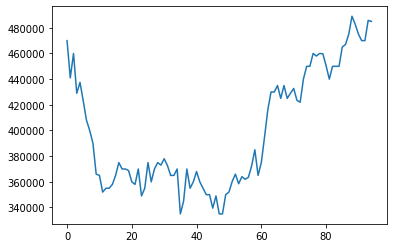

In [7]:
plt.plot(history['Median House Price'])
plt.show()

- This plot doesn't look stationary so we need to difference it to make it stationary.

In [8]:
dftest = adfuller(history['Median House Price'])
pd.Series(dftest[0:2], index=['Test Statistic','p-value'])

Test Statistic   -0.058792
p-value           0.953391
dtype: float64

- ADF test agrees with our statement. Data is not stationary since p-val>0.05

### Difference data once (Candidate 1)

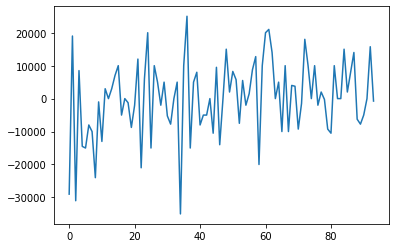

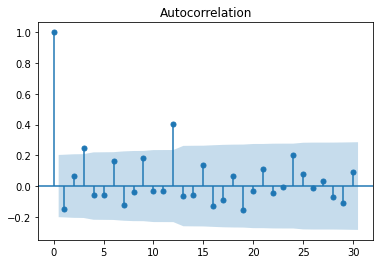

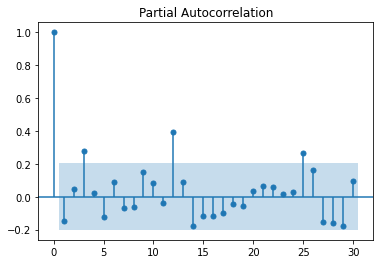

In [9]:
d1 = diff(history['Median House Price'], 1)
plt.plot(d1)
plt.show()
plot_acf(d1,lags=30) 
plt.show()
plot_pacf(d1,lags=30) 
plt.show()

- Looks better than non-differentiated model but let's check ADF test to make sure if we have reached stationary or not

In [10]:
dftest = adfuller(d1)
pd.Series(dftest[0:2], index=['Test Statistic','p-value'])

Test Statistic   -3.088139
p-value           0.027443
dtype: float64

- ADF suggests that we reached stationary
- Based on ACF and PACF plots, since they are not cutting off or tailing off, we chose p = q = 0

- Then our naive approach candidate model 1 is ARIMA (0,1,0) since we differentiated data once and reached stationary. By looking at ACF and PACF plots, we determined p = q = 0

### Difference data once more (Candidate 2)

- We can try to difference the data once more, just to see how we would do, that will be our candidate model 2 for the naive approach

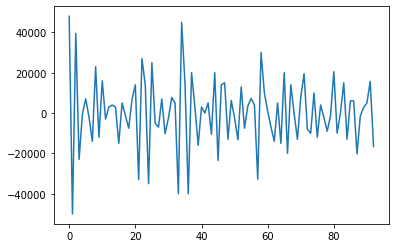

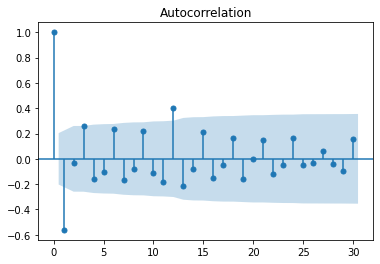

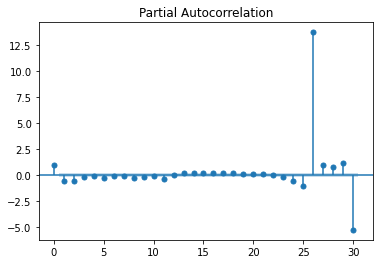

In [11]:
d2 = diff(d1, 1)
plt.plot(d2)
plt.show()
plot_acf(d2,lags=30) 
plt.show()
plot_pacf(d2,lags=30) 
plt.show()

In [12]:
dftest = adfuller(d2)
pd.Series(dftest[0:2], index=['Test Statistic','p-value'])

Test Statistic   -7.390432e+00
p-value           8.027576e-11
dtype: float64

- We still have stationary condition as expected, but this time it looks like we have a cutoff at 1 for ACF plot. This indicates q=1. PACF plot doesn't have cutoff or tail off, this indicates p=0. Our second candidate is ARIMA(0,2,1). We will let CV results decide on which naive model is better

### Naive Approach CV RMSE

In [13]:
rmse_naive1 = rmse_sarima(history['Median House Price'].values, (0, 1, 0), (0, 0, 0, 0))
rmse_naive2 = rmse_sarima(history['Median House Price'].values, (2, 2, 1), (0, 0, 0, 0))

In [14]:
rmse_naive1, rmse_naive2

(8161.607813737632, 10898.620435472754)

- They are really close but we get lower RMSE ~ 8161 with candidate 1. Candidate 1 is our finalized model for Naive approach. Let's see how it performs on Test set

## Naive Approach forecast RMSE

In [15]:
model_naive = sm.tsa.statespace.SARIMAX(history['Median House Price'], order=(0,1,0), seasonal_order=(0,0,0,0)).fit()
pred_naive = model_naive.predict(start=len(history)+1, end=len(history)+len(test))

In [16]:
test.index=pred_naive.index

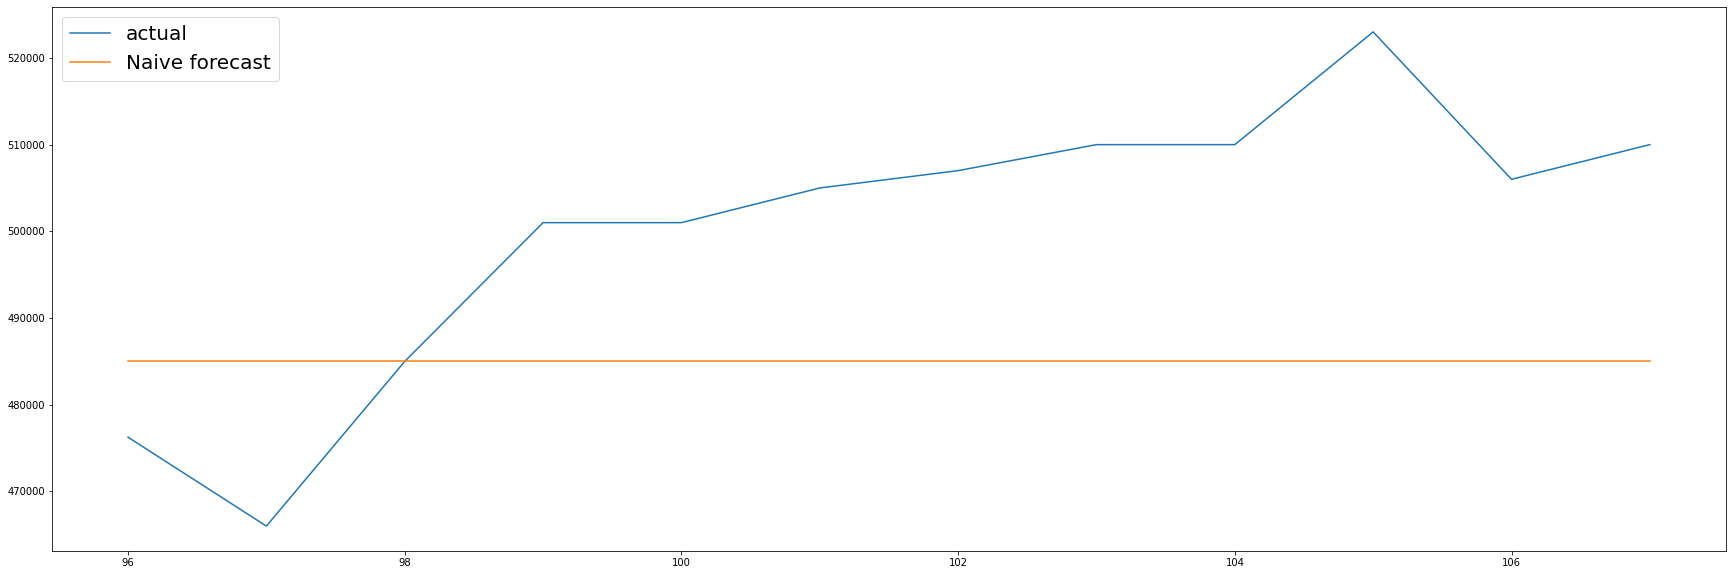

In [17]:
plt.figure(figsize=(30, 10))

plt.plot(test['Median House Price'], label='actual')
plt.plot(pred_naive, label='Naive forecast')
plt.legend(loc='upper left', fontsize=20)
plt.show()

In [18]:
rmse_naive = sqrt(mean_squared_error(test['Median House Price'], pred_naive))

In [19]:
rmse_naive

21590.048826562048

- We get RMSE ~ 21590 with naive approach. But as we can see in the plot, we're predicting the same value over the forecasting period. This doesn't seem pleasing. Let's see if this forecast can be improved by considering the impact of seasonality by chosing candidate models for SARIMA model.

# ARIMA AND SARIMA MODELS WITH PARAMETER SELECTION USING BIC

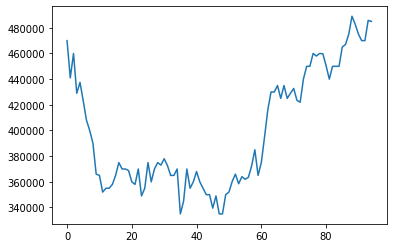

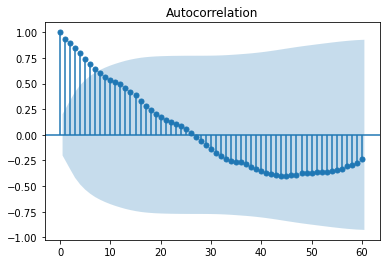

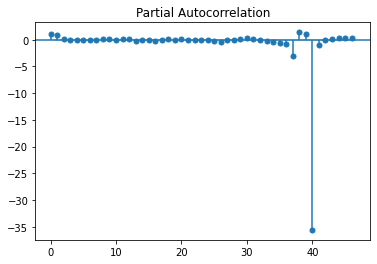

In [20]:
plt.plot(history['Median House Price'])
plt.show()
plot_acf(history['Median House Price'],lags=60) 
plt.show()
plot_pacf(history['Median House Price'],lags=46) 
plt.show()

- Based on the time series and ACF plots we can see that there is a significant trend but it's not certain if there is seasonality. Since we want to consider the effect of trend and also want to see if seasonality has an effect, we're going to use ARIMA and SARIMA models. Since we have monthly data of housing prices, we can consider half a year, and year seasonality. This way, we will have 3 candidates to look at, no seasonality, half year seasonality and year seasonality. We will let BIC model to decide on the parameters p,q,P,Q. Reason we're using BIC but not cross validation is to save time as parameter search using CV takes really long time for SARIMA models. From the naive approach, we know differencing the data once is enough, so we're not going to search for parameter 'd'. We're going to select d=1. Because we wouldn't want to over differentiate and overfit our model

### Candidate 1 ARIMA

In [21]:
p_values = range(0, 5)
d_values = [1]
q_values = range(0, 5)
P_values = [0]
m = 0
Q_values = [0]

bic_sarima(history['Median House Price'], p_values,d_values,q_values,P_values,Q_values,m, D=0)

(1916.3602502785454, (0, 1, 4), (0, 0, 0, 0))


### Candidate 2 SARIMA with half a year seasonality

In [22]:
# Half a year Seasonality

p_values = range(0, 5)
d_values = [1]
q_values = range(0, 5)
P_values = range(0, 3)
m = 6
Q_values = range(0, 3)

bic_sarima(history['Median House Price'], p_values,d_values,q_values,P_values,Q_values,m, D=1)

(1547.8727279426798, (0, 1, 4), (1, 1, 2, 6))


### Candidate 3 SARIMA with yearly seasonality

In [23]:
# Yearly Seasonality

p_values = range(0, 5)
d_values = [1]
q_values = range(0, 5)
P_values = range(0, 3)
m = 12
Q_values = range(0, 3)

bic_sarima(history['Median House Price'], p_values,d_values,q_values,P_values,Q_values,m, D=1)

(198.13900475336823, (2, 1, 1), (2, 1, 2, 12))


### CV for SARIMA candidate models

- Now that we have our candidate models, we're going to let CV decide on which model is best based on the RMSE

In [24]:
sarima1 = rmse_sarima(history['Median House Price'].values, (0, 1, 4), (0, 0, 0, 0))
sarima2 = rmse_sarima(history['Median House Price'].values, (0, 1, 4), (1, 1, 2, 6))
sarima3 = rmse_sarima(history['Median House Price'].values, (4, 1, 0), (2, 1, 0, 12))

In [25]:
sarima1, sarima2, sarima3

(8339.336390368544, 10906.637890802009, 9433.741553840777)

- Based on the CV results, ARIMA (0, 1, 4) is the winner(SARIMA with no seasonality)

## SARIMA forecast RMSE

In [26]:
model_sarima = sm.tsa.statespace.SARIMAX(history['Median House Price'], order=(0,1,4), seasonal_order=(0,0,0,0)).fit()
pred_sarima = model_sarima.predict(start=len(history)+1, end=len(history)+len(test))

In [27]:
test.index=pred_sarima.index

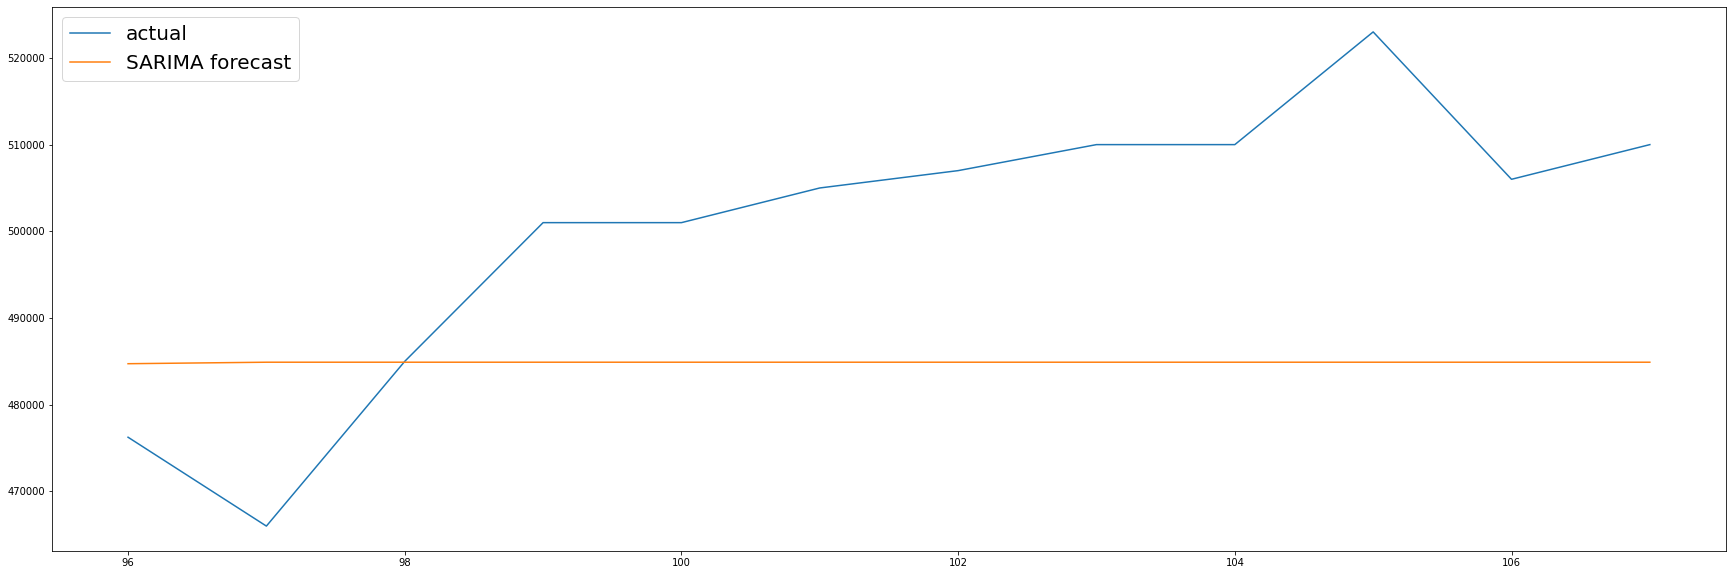

In [28]:
plt.figure(figsize=(30, 10))

plt.plot(test['Median House Price'], label='actual')
plt.plot(pred_sarima, label='SARIMA forecast')
plt.legend(loc='upper left', fontsize=20)
plt.show()

In [29]:
rmse_sarima = sqrt(mean_squared_error(test['Median House Price'], pred_sarima))

In [30]:
rmse_sarima

21652.397346898386

- Looks like we didn't perform any better than the naive approach. Let's try other algorithms

# SARIMAX

In [31]:
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
import warnings
from math import sqrt

In [32]:
df_hist = pd.read_csv('zillow-carlifornia.csv',header=0, parse_dates=True).rename(columns={'MedianSoldPrice_AllHomes.California':'MedianHousePrice'})
test = pd.read_csv('test.csv').rename(columns={'Month':'Date'})

history = df_hist[df_hist['Date']<='2015-12-31']
future = df_hist[df_hist['Date']>'2015-12-31']

In [33]:
future = future.drop(['MedianHousePrice'], axis = 1)
future['MedianHousePrice'] = list(test['Median House Price'])
future = future[['Date','MedianHousePrice', 'MedianMortageRate', 'UnemploymentRate']] 

In [34]:
history = history.set_index('Date')
future = future.set_index('Date')

In [35]:
history

,MedianHousePrice,MedianMortageRate,UnemploymentRate
Date,,,
2008-02-29,470000.0,5.29,6.3
2008-03-31,441000.0,5.44,6.2
2008-04-30,460000.0,5.42,6.4
2008-05-31,429000.0,5.47,6.3
2008-06-30,437500.0,5.60,6.2
...,...,...,...
2015-08-31,475000.0,3.95,5.2
2015-09-30,470000.0,3.87,5.1
2015-10-31,470000.0,3.80,5.0


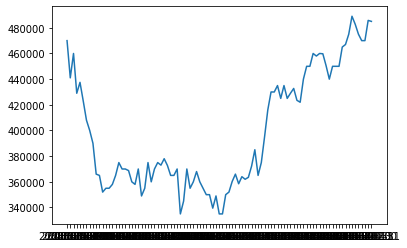

In [36]:
plt.plot(history['MedianHousePrice'])

In [37]:
#sarimax 

#normalize the features X for better prediction
#you can use StandardScaler too


from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

train_sc = sc.fit_transform(history)
test_sc = sc.transform(future)

In [38]:
from pmdarima.arima import auto_arima
model=auto_arima(train_sc[:,0], # median house price as endogenous
                 exogenous= train_sc[:,1:], # rest as exogenous
                 start_p=0, start_q=0, max_p=4, max_q=4, start_d=0, max_d=2, m=3, 
                 start_P=0, start_Q=0, max_P=3, max_Q=3, D=1,
                 trace=True,
                 suppress_warnings=True,information_criterion='oob', n_jobs = -1)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[3] intercept   : AIC=-124.694, Time=0.10 sec
 ARIMA(1,0,0)(1,1,0)[3] intercept   : AIC=-197.150, Time=1.08 sec
 ARIMA(0,0,1)(0,1,1)[3] intercept   : AIC=-158.787, Time=0.69 sec
 ARIMA(0,0,0)(0,1,0)[3]             : AIC=-126.399, Time=0.10 sec
 ARIMA(1,0,0)(0,1,0)[3] intercept   : AIC=-190.651, Time=0.32 sec
 ARIMA(1,0,0)(2,1,0)[3] intercept   : AIC=-205.857, Time=1.29 sec
 ARIMA(1,0,0)(3,1,0)[3] intercept   : AIC=-224.475, Time=1.72 sec
 ARIMA(1,0,0)(3,1,1)[3] intercept   : AIC=-222.669, Time=2.66 sec
 ARIMA(1,0,0)(2,1,1)[3] intercept   : AIC=-213.517, Time=1.62 sec
 ARIMA(0,0,0)(3,1,0)[3] intercept   : AIC=-127.465, Time=1.42 sec
 ARIMA(2,0,0)(3,1,0)[3] intercept   : AIC=-223.770, Time=1.87 sec
 ARIMA(1,0,1)(3,1,0)[3] intercept   : AIC=-223.825, Time=1.89 sec
 ARIMA(0,0,1)(3,1,0)[3] intercept   : AIC=-155.341, Time=1.80 sec
 ARIMA(2,0,1)(3,1,0)[3] intercept   : AIC=-225.957, Time=3.49 sec
 ARIMA(2,0,1)(2,1,0)[3] intercept

In [39]:
y_pred = model.predict(n_periods=len(test_sc),X=test_sc[:,1:]).reshape(-1,1)
y_pred_ = np.repeat(y_pred,3,axis=1) # duplicate the pred column x3 times to fit the scaler's shape
y_pred_inv = sc.inverse_transform(y_pred_)[:,0]# inverset the pred and take the first column (gdp)

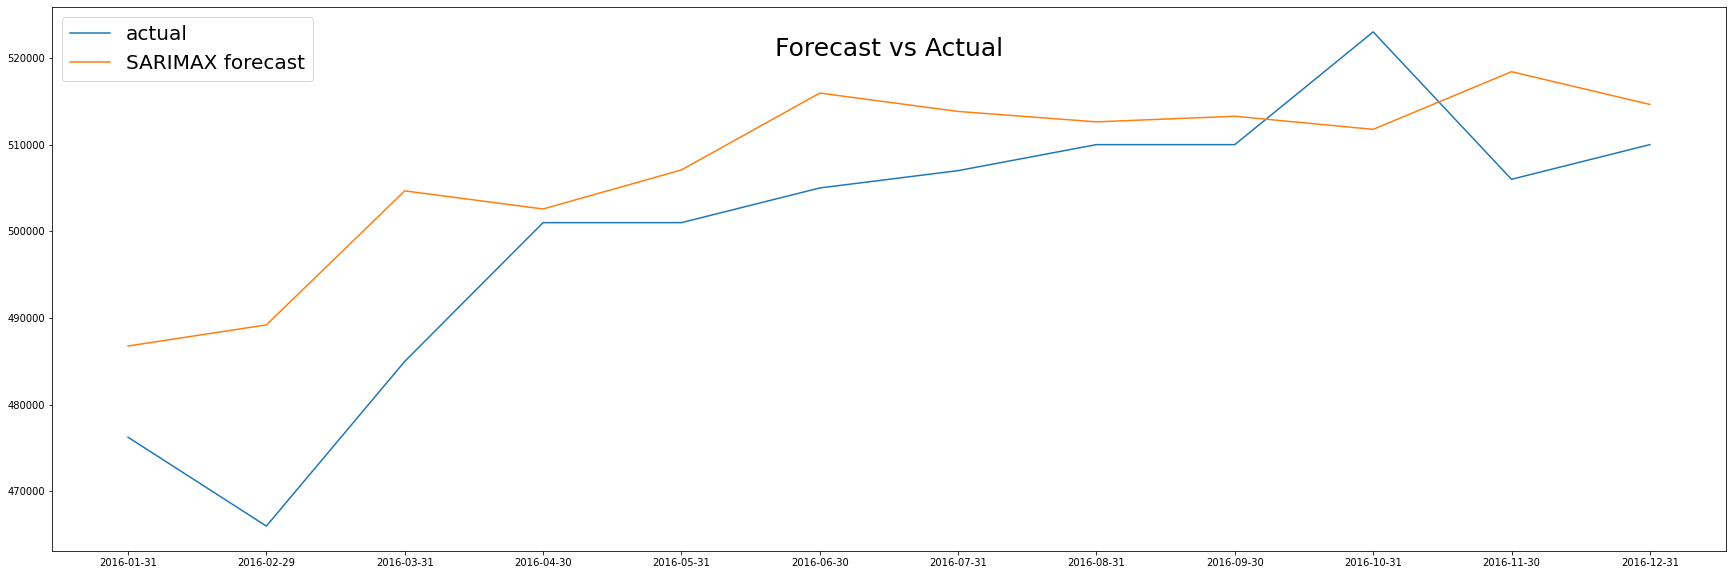

In [40]:
y_pred_series = pd.Series(y_pred_inv,index=test.index)
plt.figure(figsize=(30, 10))

plt.plot(future.MedianHousePrice, label='actual')
plt.plot(y_pred_series, label='SARIMAX forecast')
plt.legend(loc='upper left', fontsize=20)
plt.title('Forecast vs Actual', fontsize = 25, y = 0.9)
plt.show()

In [41]:
mape_test=(np.abs(np.array(future.MedianHousePrice)-np.array(y_pred_inv))/np.array(future.MedianHousePrice)).mean()
print(mape_test)

0.019126750889871893


In [42]:
rmse = sqrt(mean_squared_error(future.MedianHousePrice, y_pred_inv))
rmse

11406.07651768905

# ETS

In [43]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [44]:
def evaluate_es_model_mape(X,Trend, Seasonal,m,damped=True):
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ExponentialSmoothing(history, trend=Trend,seasonal=Seasonal,seasonal_periods=m, damped=damped)
        res = model.fit()
        yhat = res.forecast()[0] #predict one step
        predictions.append(yhat) #store prediction
        history.append(test[t]) #store observation
        # calculate out of sample error
    mape=(np.abs(np.array(test)-np.array(predictions))/np.array(test)).mean()
    return mape

In [45]:
X=np.array(history['MedianHousePrice'])
mape_1=evaluate_es_model_mape(X, Trend="additive", Seasonal="additive",m=3,damped=True)
mape_2=evaluate_es_model_mape(X, Trend="multiplicative", Seasonal="additive",m=3,damped=True)
mape_3=evaluate_es_model_mape(X, Trend="additive", Seasonal="multiplicative",m=3,damped=True)
mape_4=evaluate_es_model_mape(X, Trend="multiplicative", Seasonal="multiplicative",m=3,damped=True)
mape_5=evaluate_es_model_mape(X, Trend=None, Seasonal="additive",m=3,damped=False)
mape_6=evaluate_es_model_mape(X, Trend=None, Seasonal="multiplicative",m=3,damped=False)

In [46]:
print('Trend=additive          Seasonal=additive          ',mape_1)
print('Trend=multiplicative    Seasonal=additive          ',mape_2)
print('Trend=additive          Seasonal=multiplicative    ',mape_3)
print('Trend=multiplicative    Seasonal=multiplicative    ',mape_4)
print('Trend=None              Seasonal=additive          ',mape_5)
print('Trend=None              Seasonal=multiplicative    ',mape_6)

Trend=additive          Seasonal=additive           0.014495729004909462
Trend=multiplicative    Seasonal=additive           0.01516373012715186
Trend=additive          Seasonal=multiplicative     0.014590703740706803
Trend=multiplicative    Seasonal=multiplicative     0.014381959600608493
Trend=None              Seasonal=additive           0.01457561384117051
Trend=None              Seasonal=multiplicative     0.014382832526105855


0.015831139182742194 is the best MAPE score, from mult and mult

In [47]:
model_ets=ExponentialSmoothing(history['MedianHousePrice'], trend='mul', seasonal='mul', damped=True, seasonal_periods=3)
result_ets=model_ets.fit()
pred_ets=result_ets.forecast(len(future))
pred_ets.index=test.index

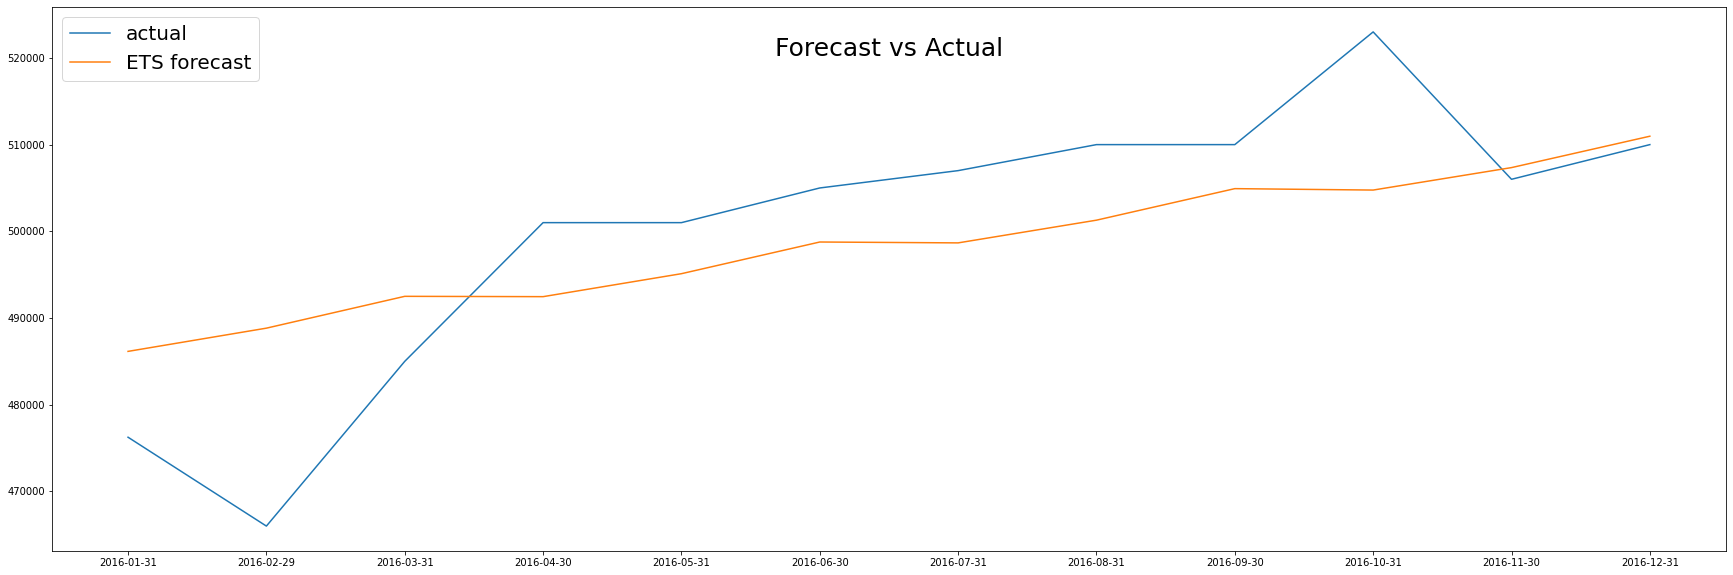

In [48]:
plt.figure(figsize=(30, 10))
#plt.plot(history, label='history')
plt.plot(future['MedianHousePrice'], label='actual')
plt.plot(pred_ets, label='ETS forecast')
plt.legend(loc='upper left', fontsize=20)
plt.title('Forecast vs Actual', fontsize = 25, y = 0.9)

plt.show()

In [49]:
mape_test=(np.abs(np.array(future.MedianHousePrice)-np.array(pred_ets))/np.array(future.MedianHousePrice)).mean()
print(mape_test)

0.017442294883934607


In [50]:
rmse = sqrt(mean_squared_error(future.MedianHousePrice, pred_ets))
rmse

10522.249175761766

# VAR

Best Model is trained without differencing --> even though VAR assumes a stationary distribution, based on the validation data, differencing none times at all is best

In [51]:
from statsmodels.tsa.arima_process import ArmaProcess
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error
from math import sqrt
from fbprophet import Prophet

In [52]:
# trend and seasonal differencing
def diff(data, interval=1):
    diff = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
    return diff

In [54]:
df_hist = pd.read_csv('zillow-carlifornia.csv',header=0, parse_dates=True).rename(columns={'MedianSoldPrice_AllHomes.California':'Median House Price'})
test = pd.read_csv('test.csv').rename(columns={'Month':'Date'})
df_hist = df_hist[df_hist['Date']<='2015-12-31']
df_hist.index = df_hist['Date']
df_hist['Median_House_Price'] = df_hist['Median House Price']
df_hist = df_hist[['Median_House_Price', 'MedianMortageRate', 'UnemploymentRate']]
test.index = test['Date']
test = test[['Median House Price']]

### No Difference

In [55]:
#split the data, test for next half year (period = 6)
period = 6
train, valid = df_hist[0:-period], df_hist[-period:]

In [56]:
# Check stationary since Var assumes data is stationary
dftest1 = adfuller(train.Median_House_Price)
dfoutput1 = pd.Series(dftest1[0:2], index=['Test Statistic','p-value'])
dftest2 = adfuller(train.MedianMortageRate)
dfoutput2 = pd.Series(dftest2[0:2], index=['Test Statistic','p-value'])
dftest3 = adfuller(train.UnemploymentRate)
dfoutput3 = pd.Series(dftest2[0:2], index=['Test Statistic','p-value'])
print (dfoutput1)
print (dfoutput2)
print (dfoutput3)

Test Statistic   -0.068773
p-value           0.952461
dtype: float64
Test Statistic   -1.728379
p-value           0.416553
dtype: float64
Test Statistic   -1.728379
p-value           0.416553
dtype: float64


In [57]:
# Use VAR to model 
model = VAR(train)
results = model.fit(maxlags=15, ic='bic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 08, Mar, 2021
Time:                     04:18:21
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    14.3071
Nobs:                     88.0000    HQIC:                   14.1054
Log likelihood:          -977.248    FPE:                1.16644e+06
AIC:                      13.9693    Det(Omega_mle):     1.02081e+06
--------------------------------------------------------------------
Results for equation Median_House_Price
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                     26341.074651     23850.837942            1.104           0.269
L1.Median_House_Price         0.986183         0.034303           28.749           0.000
L1.MedianMortag

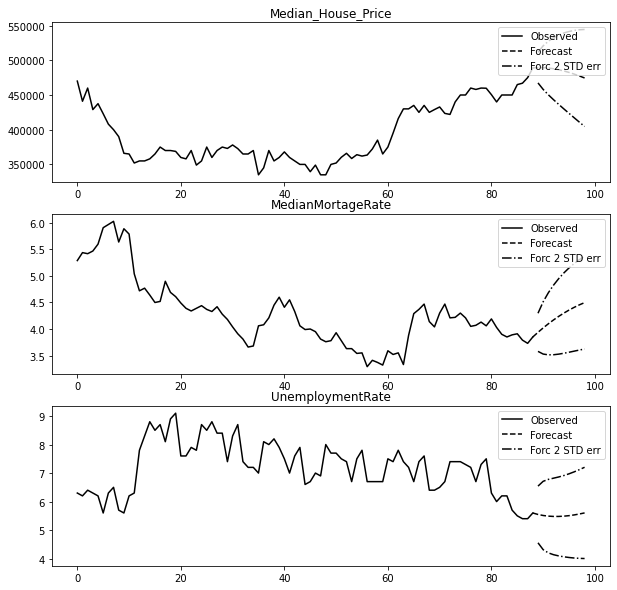

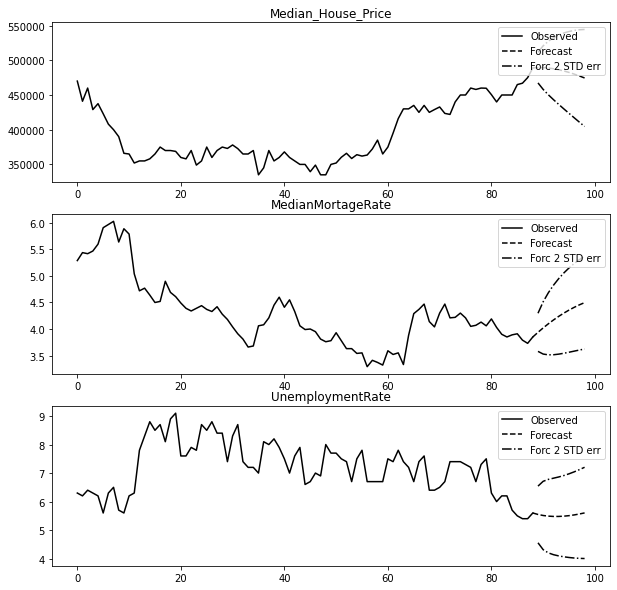

In [58]:
# forecasting
results.plot_forecast(10)

In [59]:
# forecasting
pred = results.forecast(results.y, steps = period)
dt_results = pd.DataFrame(pred, index=df_hist.index[-period:], columns=df_hist.columns + '_forecast')

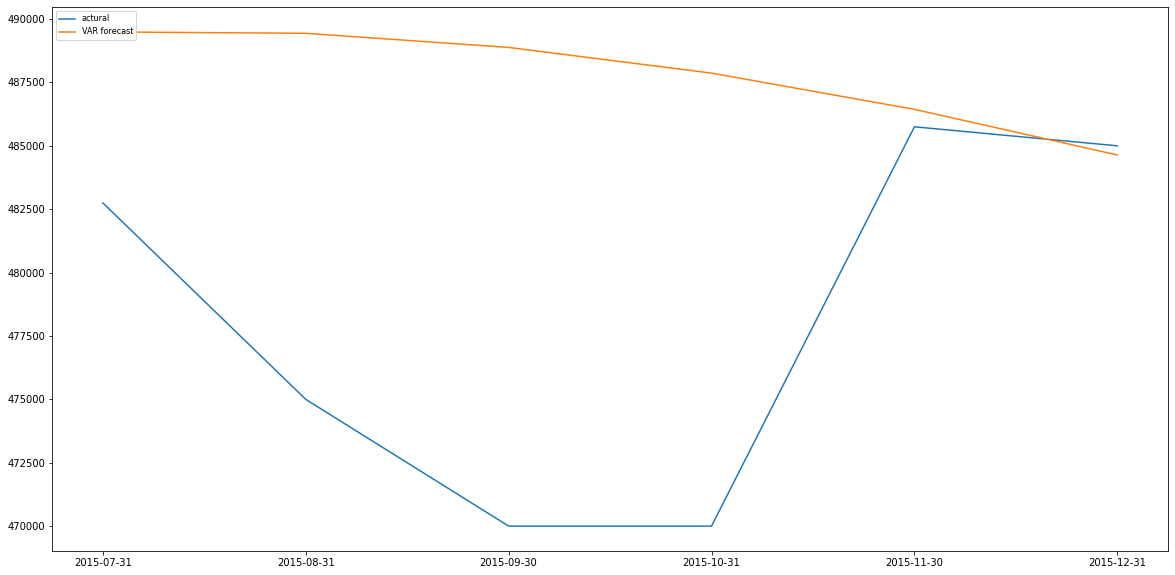

In [60]:
plt.figure(figsize=(20,10))
plt.plot(valid['Median_House_Price'], label="actural")
plt.plot(dt_results['Median_House_Price_forecast'], label='VAR forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [61]:
rmse_var = sqrt(mean_squared_error(valid['Median_House_Price'], dt_results['Median_House_Price_forecast']))
rmse_var

12451.803102624766

### Difference Once

In [62]:
train_diff_1 = train.diff().dropna() # difference twice based on ADF p-values
    
# Check stationary since Var assumes data is stationary
dftest1 = adfuller(train_diff_1.Median_House_Price, autolag='AIC')
dfoutput1 = pd.Series(dftest1[0:2], index=['Test Statistic','p-value'])
dftest2 = adfuller(train_diff_1.MedianMortageRate, autolag='AIC')
dfoutput2 = pd.Series(dftest2[0:2], index=['Test Statistic','p-value'])
dftest3 = adfuller(train_diff_1.UnemploymentRate, autolag='AIC')
dfoutput3 = pd.Series(dftest2[0:2], index=['Test Statistic','p-value'])
print (dfoutput1)
print (dfoutput2)
print (dfoutput3)

Test Statistic   -2.872365
p-value           0.048657
dtype: float64
Test Statistic   -8.221108e+00
p-value           6.426158e-13
dtype: float64
Test Statistic   -8.221108e+00
p-value           6.426158e-13
dtype: float64


So difference only once since based on ADF, it is stationary with p-value = 0.05

In [63]:
# Use VAR to model 
model = VAR(train_diff_1)
results = model.fit(maxlags=15, ic='bic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 08, Mar, 2021
Time:                     04:18:30
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    14.3233
Nobs:                     88.0000    HQIC:                   14.2729
Log likelihood:          -998.109    FPE:                1.52704e+06
AIC:                      14.2388    Det(Omega_mle):     1.47615e+06
--------------------------------------------------------------------
Results for equation Median_House_Price
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const       215.909091      1256.976234            0.172           0.864

Results for equation MedianMortageRate
           coefficient       std. error           t-stat            prob
---------------------------------------

No coefficients so only predict the Median_House_Price to be 215.909091 with the differenced data

In [64]:
pred = np.ones(period) * 215.909091
pred

array([215.909091, 215.909091, 215.909091, 215.909091, 215.909091,
       215.909091])

In [65]:
# forecasting
pred = np.ones(period) * 215.909091
dt_forecast = pd.DataFrame(pred, index=df_hist.index[-period:], columns=[df_hist.columns[0] + '_1d'])
dt_forecast

,Median_House_Price_1d
Date,
2015-07-31,215.909091
2015-08-31,215.909091
2015-09-30,215.909091
2015-10-31,215.909091
2015-11-30,215.909091
2015-12-31,215.909091


In [66]:
# inverting transformation
def invert_transformation(train, dt_forecast, columns, second_diff=False, first_diff = False):
    """Revert back the differencing to get the forecast to original scale."""
    dt_fc = dt_forecast.copy()
    for col in columns:   
        # Roll back 2nd Diff
        if second_diff:
            dt_fc[str(col)+'_1d'] = (train[col].iloc[-1]-train[col].iloc[-2]) + dt_fc[str(col)+'_1d'].cumsum()
        # Roll back 1st Diff
        if first_diff: 
            dt_fc[str(col)+'_forecast'] = train[col].iloc[-1] + dt_fc[str(col)+'_1d'].cumsum()
    return dt_fc

In [67]:
dt_results = invert_transformation(train_diff_1, dt_forecast, [train_diff_1.columns[0]], first_diff=True)
dt_results

,Median_House_Price_1d,Median_House_Price_forecast
Date,,
2015-07-31,215.909091,14215.909091
2015-08-31,215.909091,14431.818182
2015-09-30,215.909091,14647.727273
2015-10-31,215.909091,14863.636364
2015-11-30,215.909091,15079.545455
2015-12-31,215.909091,15295.454546


In [68]:
valid

,Median_House_Price,MedianMortageRate,UnemploymentRate
Date,,,
2015-07-31,482750.0,3.87,5.3
2015-08-31,475000.0,3.95,5.2
2015-09-30,470000.0,3.87,5.1
2015-10-31,470000.0,3.80,5.0
2015-11-30,485750.0,3.69,5.0
2015-12-31,485000.0,3.89,5.1


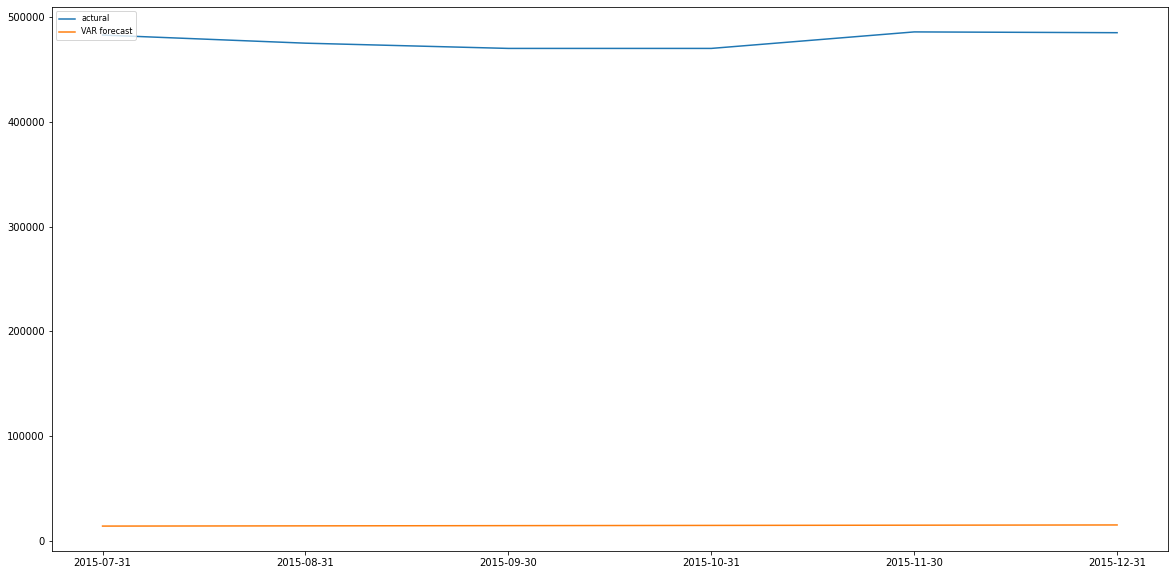

In [69]:
plt.figure(figsize=(20,10))
plt.plot(valid['Median_House_Price'], label="actural")
plt.plot(dt_results['Median_House_Price_forecast'], label='VAR forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [70]:
rmse_var = sqrt(mean_squared_error(valid['Median_House_Price'], dt_results['Median_House_Price_forecast']))
rmse_var

463374.4135919772

### Difference Twice

In [71]:
train_diff_1 = train.diff().dropna() # difference twice based on ADF p-values
train_diff_2 = train_diff_1.diff().dropna()

# Check stationary since Var assumes data is stationary
dftest1 = adfuller(train_diff_2.Median_House_Price, autolag='AIC')
dfoutput1 = pd.Series(dftest1[0:2], index=['Test Statistic','p-value'])
dftest2 = adfuller(train_diff_2.MedianMortageRate, autolag='AIC')
dfoutput2 = pd.Series(dftest2[0:2], index=['Test Statistic','p-value'])
dftest3 = adfuller(train_diff_2.UnemploymentRate, autolag='AIC')
dfoutput3 = pd.Series(dftest2[0:2], index=['Test Statistic','p-value'])
print (dfoutput1)
print (dfoutput2)
print (dfoutput3)

Test Statistic   -7.051515e+00
p-value           5.510974e-10
dtype: float64
Test Statistic   -5.156554
p-value           0.000011
dtype: float64
Test Statistic   -5.156554
p-value           0.000011
dtype: float64


In [72]:
# Use VAR to model 
model = VAR(train_diff_2)
results = model.fit(maxlags=15, ic='bic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 08, Mar, 2021
Time:                     04:18:55
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    15.4766
Nobs:                     83.0000    HQIC:                   14.7966
Log likelihood:          -909.426    FPE:                1.70282e+06
AIC:                      14.3400    Det(Omega_mle):     1.10050e+06
--------------------------------------------------------------------
Results for equation Median_House_Price
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                       651.229672       887.637314            0.734           0.463
L1.Median_House_Price        -0.886858         0.093898           -9.445           0.000
L1.MedianMortag

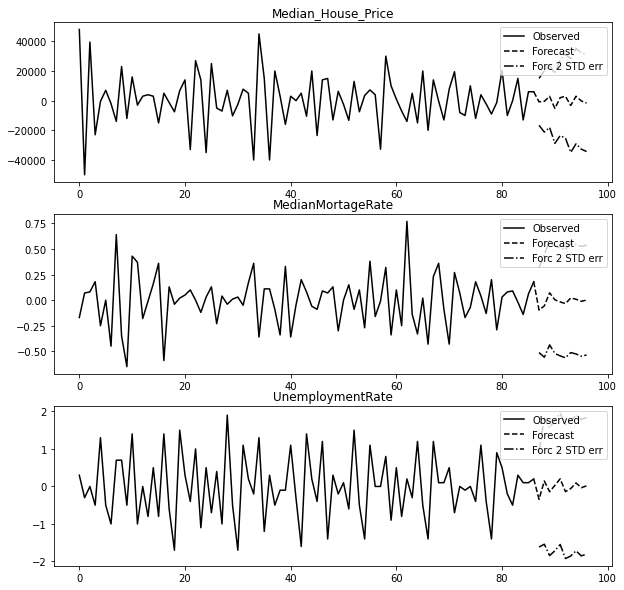

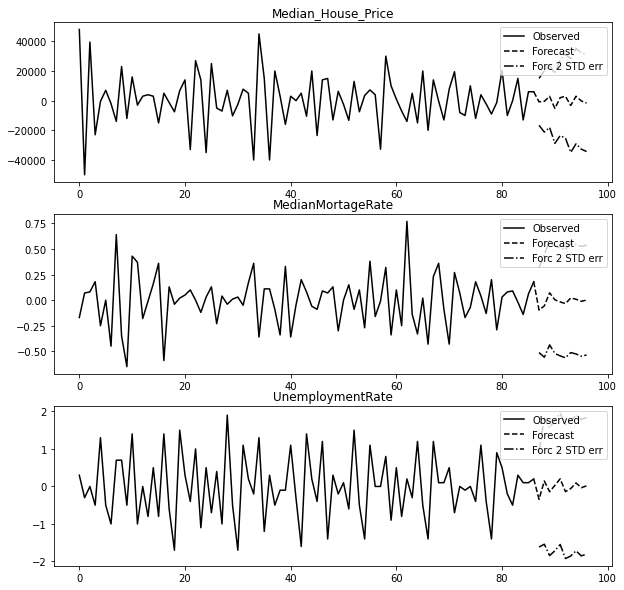

In [73]:
# forecasting
results.plot_forecast(10)

In [74]:
# forecasting
pred = results.forecast(results.y, steps = period)
dt_forecast = pd.DataFrame(pred, index=df_hist.index[-period:], columns=df_hist.columns + '_1d')
dt_forecast

,Median_House_Price_1d,MedianMortageRate_1d,UnemploymentRate_1d
Date,,,
2015-07-31,-806.965556,-0.097026,-0.343110
2015-08-31,-466.108235,-0.056582,0.144418
2015-09-30,2906.821026,0.071628,-0.141615
2015-10-31,-5281.061492,0.003376,0.028748
2015-11-30,2006.474981,-0.017700,0.203291
2015-12-31,2945.296150,-0.033491,-0.138350


In [75]:
# show inverted results in a dataframe
dt_results = invert_transformation(train_diff_2, dt_forecast, train_diff_2.columns, second_diff=True, first_diff=True)
dt_results

,Median_House_Price_1d,MedianMortageRate_1d,UnemploymentRate_1d,Median_House_Price_forecast,MedianMortageRate_forecast,UnemploymentRate_forecast
Date,,,,,,
2015-07-31,-806.965556,0.022974,-0.243110,5193.034444,0.202974,-0.043110
2015-08-31,-1273.073791,-0.033607,-0.098692,3919.960653,0.169367,-0.141803
2015-09-30,1633.747235,0.038021,-0.240307,5553.707888,0.207388,-0.382110
2015-10-31,-3647.314257,0.041397,-0.211560,1906.393631,0.248785,-0.593670
2015-11-30,-1640.839275,0.023697,-0.008269,265.554356,0.272482,-0.601939
2015-12-31,1304.456874,-0.009794,-0.146619,1570.011230,0.262688,-0.748558


## RMSE of VAR

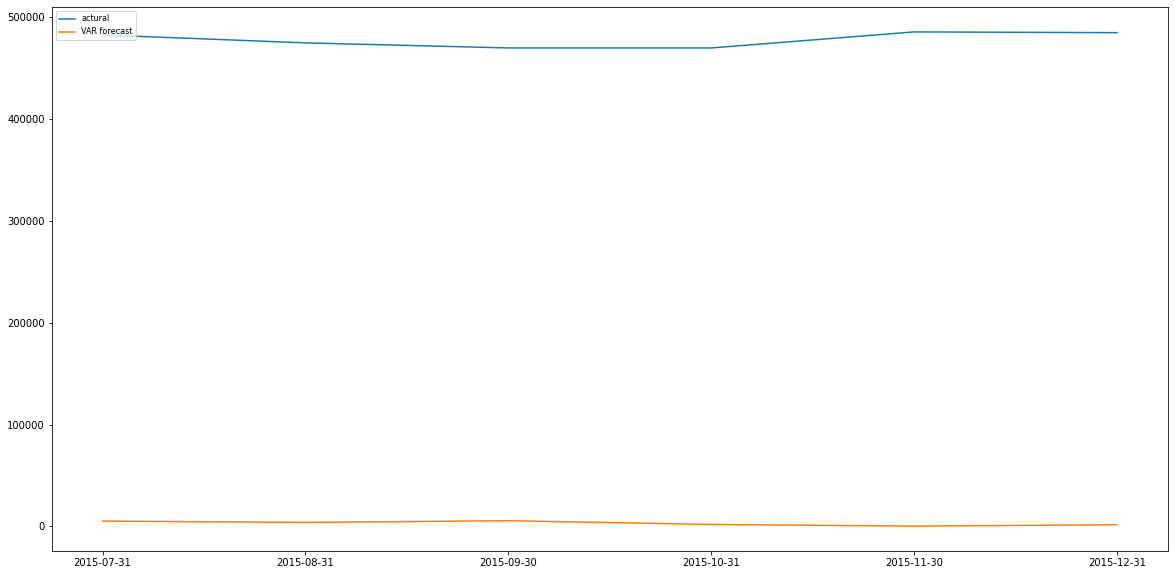

In [76]:
plt.figure(figsize=(20,10))
plt.plot(valid['Median_House_Price'], label="actural")
plt.plot(dt_results['Median_House_Price_forecast'], label='VAR forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [77]:
rmse_var = sqrt(mean_squared_error(valid['Median_House_Price'], dt_results['Median_House_Price_forecast']))
rmse_var

475078.7202150085

Therefore, using VAR with no differencing is the best as it gives the best RMSE score for the validation data. But based on other methods, still not as great.  

### Train on Entire Train Set and Check RMSE on Test Set

In [78]:
# Use the non-differenced data
model = VAR(df_hist)
results = model.fit(maxlags=15, ic='bic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 08, Mar, 2021
Time:                     04:19:05
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    14.1471
Nobs:                     94.0000    HQIC:                   13.9536
Log likelihood:          -1037.80    FPE:                1.00710e+06
AIC:                      13.8224    Det(Omega_mle):         888750.
--------------------------------------------------------------------
Results for equation Median_House_Price
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                     28600.710790     23166.335094            1.235           0.217
L1.Median_House_Price         0.981160         0.032720           29.987           0.000
L1.MedianMortag

In [79]:
# forecasting
pred = results.forecast(results.y, steps = len(test))
dt_results = pd.DataFrame(pred, index=test.index, columns=df_hist.columns + '_forecast')

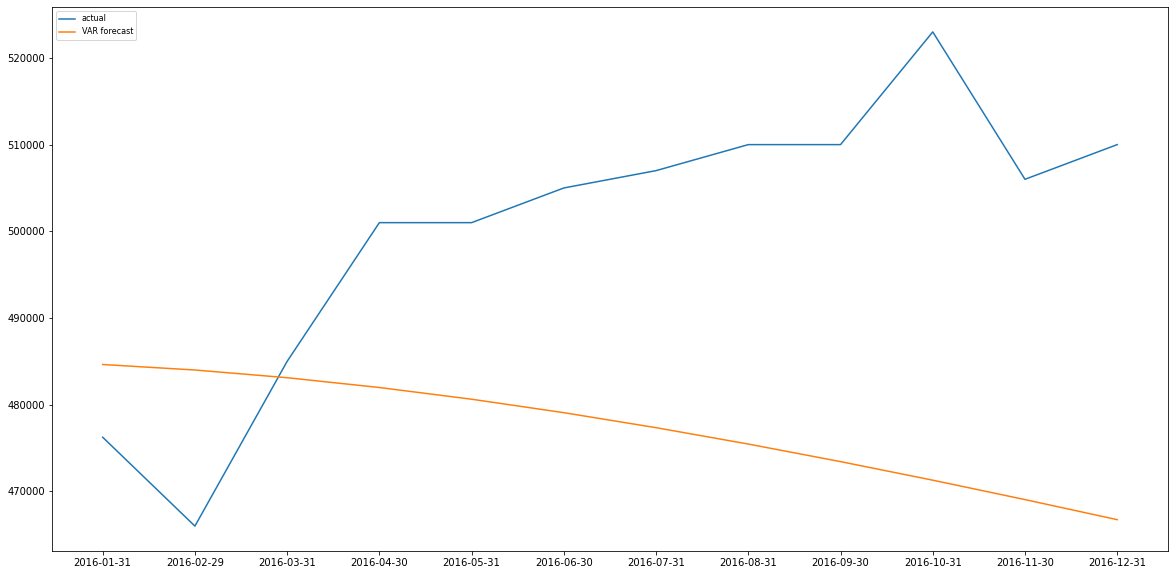

In [80]:
plt.figure(figsize=(20,10))
plt.plot(test['Median House Price'], label="actual")
plt.plot(dt_results['Median_House_Price_forecast'], label='VAR forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [81]:
# Test RMSE
rmse_var = sqrt(mean_squared_error(test['Median House Price'], dt_results['Median_House_Price_forecast']))
rmse_var

30502.148837830016

Overall, using Var doesn't work as well 

## Prophet

First split training into training and validation data

In [82]:
#split the data, test for next half year (period = 6)
period = 6
train, valid = df_hist[0:-period], df_hist[-period:]

In [83]:
valid

,Median_House_Price,MedianMortageRate,UnemploymentRate
Date,,,
2015-07-31,482750.0,3.87,5.3
2015-08-31,475000.0,3.95,5.2
2015-09-30,470000.0,3.87,5.1
2015-10-31,470000.0,3.80,5.0
2015-11-30,485750.0,3.69,5.0
2015-12-31,485000.0,3.89,5.1


In [84]:
prophet_model = Prophet()
input_df = train.reset_index().rename(columns={"Date": "ds", "Median_House_Price": "y"})[["ds", "y"]]
prophet_model.fit(input_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [85]:
future = prophet_model.make_future_dataframe(periods=int(368/2))
forecast = prophet_model.predict(future)

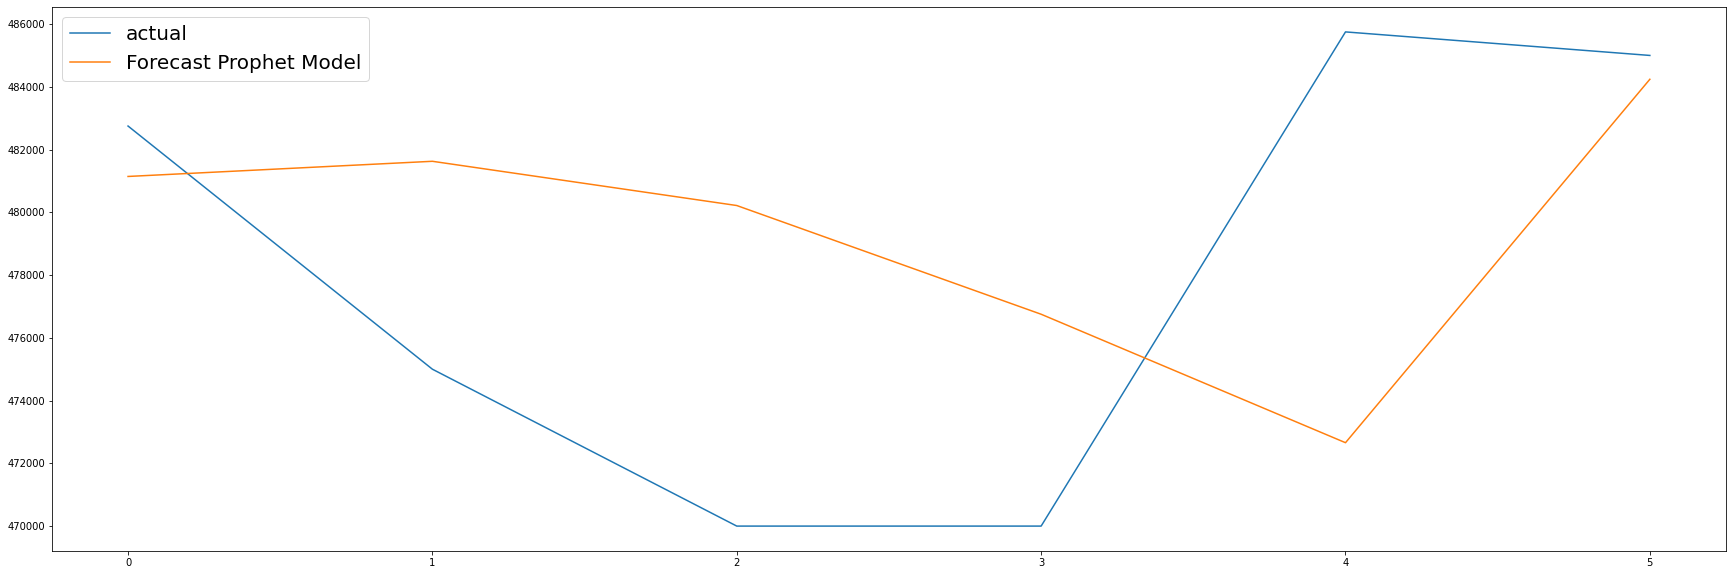

In [86]:
forecast_vals = forecast.set_index("ds").loc[np.array(valid.index)]['yhat']
plt.figure(figsize=(30, 10))
plt.plot(np.array(valid['Median_House_Price']), label='actual')
plt.plot(np.array(forecast_vals), label='Forecast Prophet Model')
plt.legend(loc='upper left', fontsize=20)
plt.show()

In [87]:
rmse_var = sqrt(mean_squared_error(np.array(valid['Median_House_Price']), np.array(forecast_vals)))
rmse_var

7836.327760820145

Now train on entire train set and check results on test set

In [88]:
prophet_model = Prophet()
input_df = df_hist.reset_index().rename(columns={"Date": "ds", "Median_House_Price": "y"})[["ds", "y"]]
prophet_model.fit(input_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [89]:
future = prophet_model.make_future_dataframe(periods=366)
forecast = prophet_model.predict(future)

In [90]:
test

,Median House Price
Date,
2016-01-31,476250
2016-02-29,466000
2016-03-31,485000
2016-04-30,501000
2016-05-31,501000
2016-06-30,505000
2016-07-31,507000
2016-08-31,510000
2016-09-30,510000


In [91]:
test['Median House Price'].astype('float64')

Date
2016-01-31    476250.0
2016-02-29    466000.0
2016-03-31    485000.0
2016-04-30    501000.0
2016-05-31    501000.0
2016-06-30    505000.0
2016-07-31    507000.0
2016-08-31    510000.0
2016-09-30    510000.0
2016-10-31    523000.0
2016-11-30    506000.0
2016-12-31    510000.0
Name: Median House Price, dtype: float64

In [92]:
np.array(forecast_vals)

array([481143.07064893, 481626.53200854, 480216.73434019, 476751.93575224,
       472657.70101953, 484240.75124227])

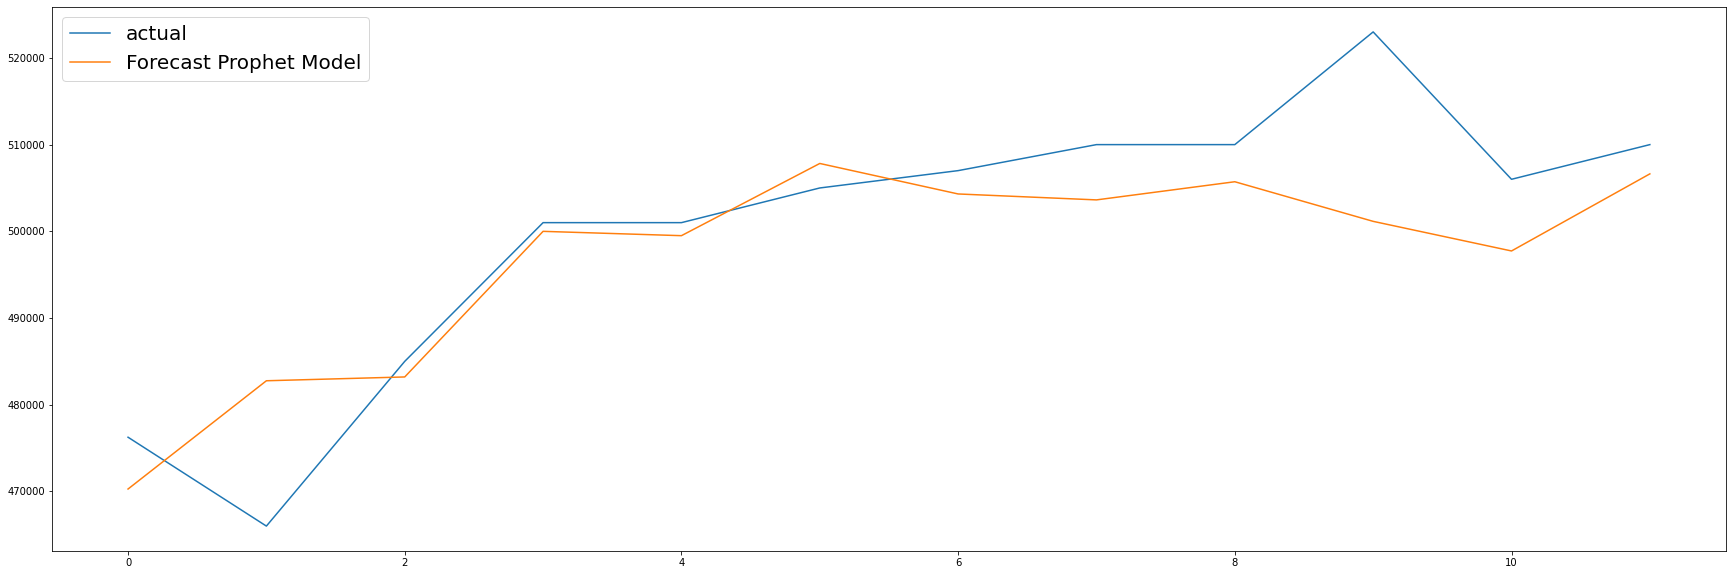

In [93]:
forecast_vals = forecast.set_index("ds").loc[np.array(test.index)]['yhat']
plt.figure(figsize=(30, 10))
plt.plot(np.array(test['Median House Price']), label='actual')
plt.plot(np.array(forecast_vals), label='Forecast Prophet Model')
plt.legend(loc='upper left', fontsize=20)
plt.show()

In [94]:
rmse_var = sqrt(mean_squared_error(np.array(test['Median House Price']), np.array(forecast_vals)))
rmse_var

8919.05986269414

Based on RMSE, getting the best results from Prophet